# How to normalize log-likelihood vectors

What is the best way to convert a log-likelihood vector into the corresponding log-probability vector, i.e. a vector of values whose exponential sum up to one? 


TLDR: just subtract the `scipy.misc.logsumexp()` of that vector.

Note: this notebook is [available on Gitbub](https://github.com/svendx4f/svendx4f.github.io/blob/dev/content/how_to_normalize_likelihood_vectors.ipynb) in case you want to play around with it.  


## Usage of logs in probability and likelihood computations


Given a set of independent events $D= \{E_i\}$ with probabilities $\{p_i\}$, the probability of the joint occurance of all events in $D$ is simply 

$$P_D = \prod\limits_i^N p_i$$

This quantity however quickly gets impossible to compute on a computer as-written above since, each $p_i$ $\in [0,1]$, the result gets smaller and smaller as the multiplication goes on and quickly leads to underflow. Usage of logarithm of probability and of likelihood is a very common computational trick to avoid that underflow which exploits the fact that a logarithm transforms a product into a sum, i.e. 

$$
P_D = e^{log(\prod\limits_i P_i))} = e^{\sum\limits_i logP_i} \max
$$


This is very common in computational probability, among others for Naive Bayes models or Hidden Markov Model, as greatly explained [in this video](https://youtu.be/-RVM21Voo7Q).

In some situation, getting "out of the log-domain" is not even necessary. For example if we have several event sets $D_i$ and want to select the most likely one, since log is a monotonically increasing function, the event set having the highest probability is also the one having the highest log likelyhood, implying that the last exponential step is unecessary:

$$
\text{arg}\max\limits_i \ e^{\sum\limits_i logP_i} = \text{arg}\max\limits_i \sum\limits_i logP_i
$$

## Normalization of a log-likelihood vector


Assume we have a learning model outputting a log likelihood vector $(L_0, ... L_{M-1})$ and we know the $M$ cases correspond to M mutually exclusive and collectively exhaustive events. What is the best way to obtain the corresponding probability vector, i.e the vector of probability that sum up to one? 

A naive approach consists in converting those log likelihoods into likelihoods and normalizing them, as follows: 

$$
P_i = \frac{e^{L_i}}{\sum_j e^{L_j}} \text{ for } i \in [0, M-1]
$$

Although this is mathematically correct, this quickly leads to a similar underflow as described above in case of very small values of $L_i$, which are very common for the reasons reminded above (i.e. being the result of multiplying tons of small probabilities). 

The alternative is to perform the normalization in log domain, i.e, to transform the $(L_0, ... L_{M-1})$ vector into another likelihood vector $(K_0, ... K_{M-1})$, such that: 

$$
P_i = e^{K_i}\in [0, M-1]
$$

Putting the last two relations together, we directly see we can compute the $K_i$ from the $L_i$ without leaving the log domain: 

$$
K_i = L_i - log \sum_j e^{L_j}
$$

Which is not prone to underflow as above. Converting that to a probability vector is just a matter of taking the exponential, which this time is also less prone to underflow (since the $K_i$ should typically be much larger than the $L_i$)


## Implementation in scipy

In python, [scipy comes with](http://docs.scipy.org/doc/scipy/reference/generated/scipy.misc.logsumexp.html) a numerically stable way of computing the later term, so converting the log-likelihood vector L into the corresponding log-probability vector is a simple matter of: 

```python

import scipy
K = L - scipy.misc.logsumexp(L)

```

# Example

I built a small example to investigate just how quickly the rounding error can occur. It turns out that with the parameters I entered, they occur very quickly. Feel free to download this notebook and play with the noise of number of classes values and see what gets out. 

In [617]:
from __future__ import division
import pandas as pd
import numpy as np
import scipy as sc
import scipy.stats as stats
import sys

My example is simulating inference with a probabilistic classifier that allocates to each observation a probability of being in each of $K$ class. 

I simulate such classifier by assuming that we have $n$ observations from which my fake models generates $n$ probability vectors. My imaginary classifier below has no bias but quite a serious variance: 

In [624]:
# number of different values is some discrete random variable Y that we want to estimate
K = 12

# the true class underlying all of the observation we're generating
y_true = 8

# Weights given to each class by the classifier => this simulates a classifier
# wich should more often output a higher probability to the true class y_true, although reading 
# include a serious noise (standard deviation is 4, while we just have 12 classes)
classifier_p = stats.norm.pdf(x=range(K), loc=y_true, scale=4)
classifier_p = classifier_p / classifier_p.sum()

def make_up_some_observation_probs(n):
    """
    Generates a (n*K) matrix made of n probability rows corresponding to n observations
    This simulatates some upstream learning model that generate such probability vector
    for each of the n observed data.     
    """
    
    def random_observation_p():
        ""
        obs = np.array([np.random.beta(alpha, 1-alpha) for alpha in y_true_p])
        obs[obs == 0] = sys.float_info.min
        
        return obs / obs.sum()

    return  np.array([random_observation_p() for _ in range(n)])


## Class inference

Any call to `make_up_some_observation_probs` above generates a full set of $n$ predicted probability vectors from which we have to infer a single resulting probability vector of being in each class. That otherwise, the assumption is that the $n$ samples are all part of the same class and we're trying to determine which one is the most likely. 

Once this probability vector is available, we select the class having the highest probability with the method below. In practise, this problem would _not_ require to convert log-probability nor log-likelihoods to probability: just comparing the log values provide the most likely class. I insist of performing the conversion though in order to observe how quickly the errors due to numerical computations occur. 

In [626]:
def map_predict(prob_vect):
    if np.isnan(prob_vect.sum()):
        return np.nan
    return np.argmax(prob_vect)

# Building the resulting probability vector 

This section implements 3 inference models, all expecting a matrix of `n` probability vectors, corresponding to the `n` observed samples. 

In [623]:
def straight_forward_map(obs_probabilities):
    """
    This inference models works completelly in probability space: it computes the likelyhood 
    of each class by simply multiplying the sequence of predicted probabilities, and normalize the result    
    """
    
    likelihoods = obs_probabilities.prod(axis=0)
    probability = likelihoods / likelihoods.sum()
    return map_predict(probability)
    
    
def normalized_log_sum_map(obs_probabilities):
    """
    This inference models solves the first underflow error by summing up log-likelihoods. 
    
    However, in order to normalize it into a probability vector, this implementaion first 
    take the exponential of the likelihood and normalize the result, which also lead to 
    underflow issues.
    """

    log_likelihoods = np.log(obs_probabilities).sum(axis=0)

    # getting out of log domain too soon!
    likelihoods = np.exp(log_likelihoods)
    probability = likelihoods / likelihoods.sum()    
    
    return map_predict(probability)


def normalized_log_space_map(obs_probabilities):
    """
    Finally, this inference models computes the probability vector by summing up the 
    log likelihoods, normalizing the result by substracting its log-sum-exp and then 
    only get out of the log space. 
    """

    log_likelihoods = np.log(obs_probabilities).sum(axis=0)
    log_probs = log_likelihoods - sc.misc.logsumexp(log_likelihoods)
    probability = np.exp(log_probs)
    return map_predict(probability)


In [608]:
%%time

def run_experiment(test_size):
    """
    This experiment simply generates 100 (noisy) learning outcomes of various size
    and submit them to each of the 3 inference models above.           
    """
    
    observations = make_up_some_observation_probs(test_size)
    
    return [
        straight_forward_map(observations), 
        normalized_log_sum_map(observations),
        normalized_log_space_map(observations)
    ]

results = pd.DataFrame([["%05d observations" % test_size] + run_experiment(test_size)
              for test_size in [10, 30, 50, 100, 150, 500, 1000, 5000, 10000]
              for _ in range(100)],
               columns=["test_size", "m1", "m2", "m3"]
            )

CPU times: user 45.4 s, sys: 573 ms, total: 46 s
Wall time: 45.8 s


# Results

In [618]:
import readline

%load_ext rpy2.ipython
%R library("ggplot2")

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


array(['ggplot2', 'tools', 'stats', 'graphics', 'grDevices', 'utils', 'datasets', 'methods', 'base'], 
      dtype='|S9')

In [609]:
results_named = results.rename(columns={
        "m1": "straight_forward_map",
        "m2": "normalized_log_sum_map",
        "m3": "normalized_log_space_map",        
    })


results_m = pd.melt(results_named, id_vars=["test_size"], var_name="method", value_name="predicted_class")

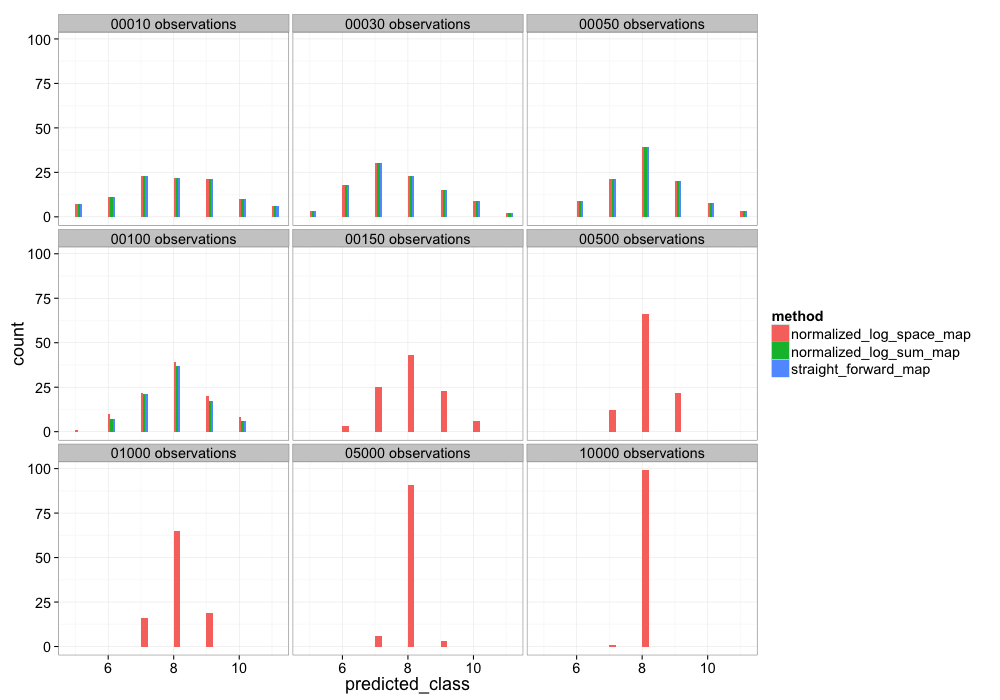

In [610]:
%%R -i results_m --width 1000 --height 700

g <- ggplot(data=results_m)
g <- g + geom_histogram(aes(x=predicted_class, fill=method), position="dodge")
g <- g + facet_wrap(~test_size, ncol=3)
g <- g + theme_bw(base_size=18)

print(g)

The graph aboves shows the distribution of selected class by each inference model given a set of probability vector of various size. 

The probability vectors constructed from the fake model have a lot of variance, which explain why the top left histogram with 10 and 30 observation are so often wrong about which true class should be predicted. 

As the number of observations grows, variance decreases as expected and the true class gets predicted correctly most of the time. 

On the lower histograms, only the `normalize_log_space_map` algorithm, corresponding to the third algorithm above, is present: the other two models both already start to underflow for some classes and are unable to produce a result. With this particular set of parameter for my toy problem this occurs as soon as the dataset reaches 150 samples, which is fairly small. The third one by comparaison has no problem handling 10000 samples. 